In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)



[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [5]:

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,3,4,5,6,),
)
def gausssian_mixture_vectorize(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    variance,
    outlier_prob: float,
    outlier_volume: float,
    filter_size: int,
):
    distances = (
        observed_xyz[ij[0], ij[1], :3] - 
        jax.lax.dynamic_slice(rendered_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    )
    probability = jax.scipy.special.logsumexp(
        jax.scipy.stats.norm.logpdf(
            distances,
            loc=0.0,
            scale=jnp.sqrt(variance)
        ).sum(-1) - jnp.log(observed_xyz.shape[0] * observed_xyz.shape[1])
    )
    return jnp.logaddexp(probability + jnp.log(1.0 - outlier_prob), jnp.log(outlier_prob) - jnp.log(outlier_volume))


def threedp3_likelihood_per_pixel(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    log_probabilities = gausssian_mixture_vectorize(
        indices, observed_xyz,
        rendered_xyz_padded,
        variance, outlier_prob, outlier_volume, filter_size
    )
    return log_probabilities

threedp3_likelihood_per_pixel_jit = jax.jit(threedp3_likelihood_per_pixel, static_argnames=('filter_size',))

def threedp3_likelihood_per_pixel_ij(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    
    filter_data = jax.lax.dynamic_slice(rendered_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    distances = jnp.linalg.norm(
        observed_xyz[ij[0], ij[1], :3] - filter_data,
        axis=-1
    )
    squared_filter_z = filter_data[:,:,2]**2
    probability = jax.scipy.stats.norm.logpdf(
        distances,
        loc=0.0,
        scale=jnp.sqrt(variance)
    ) + jnp.log(squared_filter_z) - jnp.log(squared_filter_z.sum())
    return distances, squared_filter_z, probability

def threedp3_likelihood(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size
):
    log_probabilities_per_pixel = threedp3_likelihood_per_pixel(
        observed_xyz, rendered_xyz, variance,
        outlier_prob, outlier_volume, filter_size
    )
    return log_probabilities_per_pixel.sum()

In [6]:
b.utils.ycb_loader.MODEL_NAMES

['002_master_chef_can',
 '003_cracker_box',
 '004_sugar_box',
 '005_tomato_soup_can',
 '006_mustard_bottle',
 '007_tuna_fish_can',
 '008_pudding_box',
 '009_gelatin_box',
 '010_potted_meat_can',
 '011_banana',
 '019_pitcher_base',
 '021_bleach_cleanser',
 '024_bowl',
 '025_mug',
 '035_power_drill',
 '036_wood_block',
 '037_scissors',
 '040_large_marker',
 '051_large_clamp',
 '052_extra_large_clamp',
 '061_foam_brick']

In [7]:
def get_depth_image(image):
    mval = image[image < image.max()].max()
    return b.get_depth_image(image, max=mval)

def get_poses_non_jit(contact_params, id_table, id):
    sg = b.scene_graph.SceneGraph(
        root_poses=jnp.array([table_pose, jnp.eye(4)]),
        box_dimensions=jnp.array([b.RENDERER.model_box_dims[id_table], b.RENDERER.model_box_dims[id]]),
        parents=jnp.array([-1, 0]),
        contact_params=jnp.array([jnp.zeros(3), contact_params]),
        face_parent=jnp.array([-1,2]),
        face_child=jnp.array([-1,3]),
    )
    poses = sg.get_poses()
    return poses
get_poses = jax.jit(get_poses_non_jit)

def render_image_non_jit(contact_params):
    id_table = 21
    id = 13
    poses = get_poses_non_jit(contact_params, id_table, id)
    img = b.RENDERER.render(
        poses , jnp.array([id_table, id])
    )[...,:3]
    return img
render_image = jax.jit(render_image_non_jit)

scorer = lambda obs, c, var, outlier_prob, outlier_volume: threedp3_likelihood(
    obs, render_image_non_jit(c), var, outlier_prob, outlier_volume, 3
)
scorer_jit = jax.jit(scorer)
sweep_scorer = jax.jit(jax.vmap(
    scorer 
    ,in_axes=(None, 0, None, None, None)))

# sweep_scorer = jax.jit(jax.vmap(jax.vmap(jax.vmap(
#     scorer, 
#     ,in_axes=(None, None, None, 0, None))
#     ,in_axes=(None, None, 0, None, None))
#     ,in_axes=(None, 0, None, None, None)))


In [16]:
width = 0.015
ang = jnp.pi
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    17,17,100
)

In [17]:
key = jax.random.PRNGKey(10)

In [18]:
variance = 0.0001
outlier_prob = 0.001
outlier_volume = 1.0

In [19]:
for experiment_iteration in tqdm(range(50)):
    high = jnp.array([0.1, 0.1, jnp.pi])
    low = jnp.array([-0.1, -0.1, -jnp.pi])
    key = jax.random.split(key, 1)[0]
    
    gt_contact = jax.random.uniform(key, shape=(3,)) * (high - low) + low
    # gt_contact = gt_contact.at[2].set(jnp.pi)
    # gt_contact = jnp.array([-0.03, -0.09, -0.51 ])
    # gt_contact = jnp.array([-0.03, -0.09, -0.51 + jnp.pi ])
    observation = render_image(gt_contact)
    get_depth_image(observation[...,2])
    print(scorer_jit(observation, gt_contact, variance, outlier_prob, outlier_volume))
    contact_param_grid = gt_contact + contact_param_deltas
    
    weights =  jnp.concatenate([
        sweep_scorer(observation, cp, variance, outlier_prob, outlier_volume)
        for cp in jnp.array_split(contact_param_grid, 100)
    ],axis=0)
    
    key2 = jax.random.PRNGKey(0)
    sampled_indices = jax.random.categorical(key2, weights.reshape(-1), shape=(1000,))
    sampled_indices = jnp.unravel_index(sampled_indices, weights.shape)[0]
    sampled_params = contact_param_grid[sampled_indices]
    actual_params = gt_contact
    
    fig = plt.figure(constrained_layout=True)
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.set_aspect(1.0)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
    ax.add_patch(circ)
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-2.0, 2.0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter(-jnp.sin(sampled_params[:,2]),-jnp.cos(sampled_params[:,2]),label="Posterior Samples", alpha=0.5, s=15)
    ax.scatter(-jnp.sin(actual_params[2]),-jnp.cos(actual_params[2]), color=(1.0, 0.0, 0.0),label="Actual", alpha=0.9, s=10)
    ax.set_title("Posterior on Orientation (top view)")
    ax.legend(fontsize=7)
    # plt.show()
    plt.savefig(f'{experiment_iteration:05d}.png')
    plt.clf()

  0%|                                                            | 0/50 [00:00<?, ?it/s]

37091.543


  2%|█                                                   | 1/50 [00:10<08:43, 10.68s/it]

37113.234


  4%|██                                                  | 2/50 [00:11<04:00,  5.01s/it]

37140.016


  6%|███                                                 | 3/50 [00:12<02:30,  3.20s/it]

37182.41


  8%|████▏                                               | 4/50 [00:13<01:48,  2.35s/it]

37120.953


 10%|█████▏                                              | 5/50 [00:14<01:24,  1.87s/it]

36992.89


 12%|██████▏                                             | 6/50 [00:15<01:10,  1.59s/it]

37059.883


 14%|███████▎                                            | 7/50 [00:16<01:00,  1.41s/it]

37271.01


 16%|████████▎                                           | 8/50 [00:17<00:53,  1.28s/it]

37184.707


 18%|█████████▎                                          | 9/50 [00:18<00:49,  1.20s/it]

37206.496


 20%|██████████▏                                        | 10/50 [00:19<00:46,  1.15s/it]

37379.594


 22%|███████████▏                                       | 11/50 [00:21<00:43,  1.11s/it]

37116.023


 24%|████████████▏                                      | 12/50 [00:22<00:41,  1.09s/it]

37066.914


 26%|█████████████▎                                     | 13/50 [00:23<00:39,  1.08s/it]

37056.92


 28%|██████████████▎                                    | 14/50 [00:24<00:38,  1.06s/it]

37113.008


 30%|███████████████▎                                   | 15/50 [00:25<00:36,  1.05s/it]

37096.46


 32%|████████████████▎                                  | 16/50 [00:26<00:35,  1.04s/it]

37369.363


 34%|█████████████████▎                                 | 17/50 [00:27<00:34,  1.04s/it]

37124.203


 36%|██████████████████▎                                | 18/50 [00:28<00:33,  1.04s/it]

36950.24


 38%|███████████████████▍                               | 19/50 [00:29<00:32,  1.04s/it]

37104.336


 40%|████████████████████▍                              | 20/50 [00:30<00:31,  1.04s/it]

37115.848


/var/tmp/ipykernel_813201/2689616434.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True)
 42%|█████████████████████▍                             | 21/50 [00:31<00:30,  1.04s/it]

37206.098


 44%|██████████████████████▍                            | 22/50 [00:32<00:29,  1.04s/it]

37271.5


 46%|███████████████████████▍                           | 23/50 [00:33<00:28,  1.04s/it]

37252.484


 48%|████████████████████████▍                          | 24/50 [00:34<00:26,  1.04s/it]

37018.758


 50%|█████████████████████████▌                         | 25/50 [00:35<00:25,  1.03s/it]

37187.688


 52%|██████████████████████████▌                        | 26/50 [00:36<00:24,  1.03s/it]

37302.176


 54%|███████████████████████████▌                       | 27/50 [00:37<00:23,  1.02s/it]

37400.11


 56%|████████████████████████████▌                      | 28/50 [00:38<00:22,  1.03s/it]

37289.906


 58%|█████████████████████████████▌                     | 29/50 [00:39<00:23,  1.10s/it]

37259.047


 60%|██████████████████████████████▌                    | 30/50 [00:40<00:21,  1.08s/it]

37134.28


 62%|███████████████████████████████▌                   | 31/50 [00:41<00:20,  1.07s/it]

37064.5


 64%|████████████████████████████████▋                  | 32/50 [00:42<00:18,  1.05s/it]

37354.61


 66%|█████████████████████████████████▋                 | 33/50 [00:43<00:17,  1.04s/it]

37363.277


 68%|██████████████████████████████████▋                | 34/50 [00:44<00:16,  1.03s/it]

37063.695


 70%|███████████████████████████████████▋               | 35/50 [00:46<00:15,  1.04s/it]

36956.004


 72%|████████████████████████████████████▋              | 36/50 [00:47<00:14,  1.04s/it]

36942.914


 74%|█████████████████████████████████████▋             | 37/50 [00:48<00:13,  1.03s/it]

37123.758


 76%|██████████████████████████████████████▊            | 38/50 [00:49<00:12,  1.04s/it]

37085.445


 78%|███████████████████████████████████████▊           | 39/50 [00:50<00:11,  1.03s/it]

37291.316


 80%|████████████████████████████████████████▊          | 40/50 [00:51<00:10,  1.03s/it]

37064.703


 82%|█████████████████████████████████████████▊         | 41/50 [00:52<00:09,  1.02s/it]

36939.305


 84%|██████████████████████████████████████████▊        | 42/50 [00:53<00:08,  1.04s/it]

37308.234


 86%|███████████████████████████████████████████▊       | 43/50 [00:54<00:07,  1.04s/it]

37098.477


 88%|████████████████████████████████████████████▉      | 44/50 [00:55<00:06,  1.04s/it]

37105.867


 90%|█████████████████████████████████████████████▉     | 45/50 [00:56<00:05,  1.04s/it]

37218.32


 92%|██████████████████████████████████████████████▉    | 46/50 [00:57<00:04,  1.04s/it]

37022.867


 94%|███████████████████████████████████████████████▉   | 47/50 [00:58<00:03,  1.03s/it]

37269.11


 96%|████████████████████████████████████████████████▉  | 48/50 [00:59<00:02,  1.03s/it]

37156.082


 98%|█████████████████████████████████████████████████▉ | 49/50 [01:00<00:01,  1.03s/it]

37156.617


100%|███████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.24s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

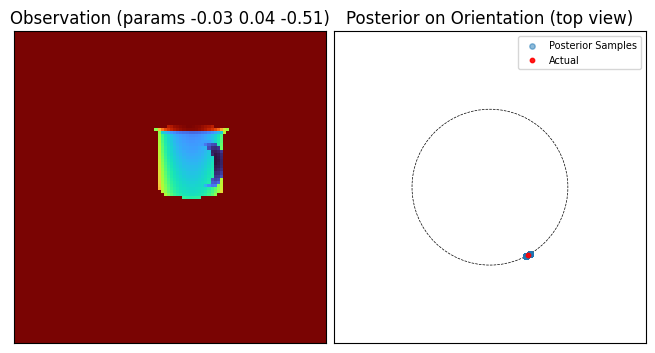

In [20]:
high = jnp.array([0.1, 0.1, jnp.pi])
low = jnp.array([-0.1, -0.1, -jnp.pi])
key = jax.random.split(key, 1)[0]

gt_contact = jax.random.uniform(key, shape=(3,)) * (high - low) + low
gt_contact = jnp.array([-0.03, -0.09, -0.51 ])
gt_contact = jnp.array([-0.05, 0.09,+ jnp.pi ])
gt_contact = jnp.array([-0.03, 0.04,-0.51 ])
# gt_contact = jnp.array([-0.03, 0.04,+jnp.pi])
observation = render_image(gt_contact)
get_depth_image(observation[...,2])

contact_param_grid = gt_contact + contact_param_deltas

weights =  jnp.concatenate([
    sweep_scorer(observation, cp, variance, outlier_prob, outlier_volume)
    for cp in jnp.array_split(contact_param_grid, 100)
],axis=0)

key2 = jax.random.PRNGKey(0)
sampled_indices = jax.random.categorical(key2, weights.reshape(-1), shape=(100,))
sampled_indices = jnp.unravel_index(sampled_indices, weights.shape)[0]
sampled_params = contact_param_grid[sampled_indices]
actual_params = gt_contact

fig = plt.figure(constrained_layout=True)
widths = [1, 1]
heights = [2]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax = fig.add_subplot(spec[0, 0])
ax.imshow(jnp.array(get_depth_image(observation[...,2])))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")


ax = fig.add_subplot(spec[0, 1])
ax.set_aspect(1.0)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
ax.add_patch(circ)
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.scatter(-jnp.sin(sampled_params[:,2]),-jnp.cos(sampled_params[:,2]),label="Posterior Samples", alpha=0.5, s=15)
ax.scatter(-jnp.sin(actual_params[2]),-jnp.cos(actual_params[2]), color=(1.0, 0.0, 0.0),label="Actual", alpha=0.9, s=10)
ax.set_title("Posterior on Orientation (top view)")
ax.legend(fontsize=7)
# plt.savefig(f'{experiment_iteration:05d}.png')
# plt.clf()
plt.show()

In [ ]:
b.utils.ycb_loader.MODEL_NAMES

In [140]:
print(scorer_jit(observation, sampled_params[0], variance, outlier_prob, outlier_volume))
print(scorer_jit(observation, gt_contact, variance, outlier_prob, outlier_volume))

39120.23
39120.23


In [281]:
latent_image_good = render_image(gt_contact)[...,:3]
latent_image_bad = render_image(sampled_params[0])[...,:3]
scores_good = threedp3_likelihood_per_pixel_jit(observation, latent_image_good, variance, outlier_prob, outlier_volume, 4)
scores_bad = threedp3_likelihood_per_pixel_jit(observation, latent_image_bad, variance, outlier_prob, outlier_volume, 4)

filter_size= 4
ij = jnp.array([40,50])
assert scores_good[ij[0], ij[1]] < scores_bad[ij[0], ij[1]]
observation_edit = observation[...,2].at[ij[0]-filter_size:ij[0]+filter_size,ij[1]-filter_size:ij[1]+filter_size].set(100.0)
b.viz.scale_image(b.get_depth_image(observation_edit),4)

AssertionError: 

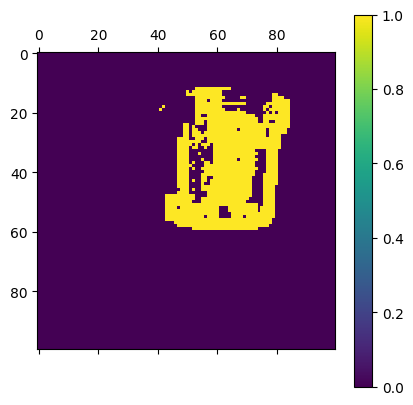

In [282]:
plt.matshow(scores > scores_gt)
plt.colorbar()

In [283]:
distances_bad, squared_filter_bad, probability_bad = threedp3_likelihood_per_pixel_ij(ij, observation, latent_image_bad, variance, outlier_prob, outlier_volume,4)
distances_good, squared_filter_good, probability_good  = threedp3_likelihood_per_pixel_ij(ij, observation, latent_image_good, variance, outlier_prob, outlier_volume,4)
print(probability_bad.max())
print(probability_good.max())

-3.062764
-3.0528426


In [261]:
print(distances_bad[4,4],distances_good[4,4])

0.015138281 0.0


In [262]:
print(probability_bad[4,4], probability_good[4,4])

-3.0477264 -6.5067205


In [263]:
print(squared_filter_bad[4,4], squared_filter_good[4,4])

0.010578943 0.013852889


In [264]:
print(squared_filter_bad.sum(), squared_filter_good.sum() )

0.8789958 37.006935


In [269]:
print(squared_filter_bad / squared_filter_bad.sum())
print(squared_filter_good / squared_filter_good.sum() )

[[0.01437394 0.0134089  0.01272168 0.01218773 0.01172397 0.01137495
  0.01107647 0.01080908 0.01057336]
 [0.01455248 0.01348458 0.01278045 0.01225416 0.01182344 0.01144719
  0.0111374  0.01086731 0.01063328]
 [0.01464109 0.01358145 0.01287223 0.01232456 0.01187292 0.01151115
  0.01119879 0.0109259  0.01069097]
 [0.01475344 0.01370425 0.01294535 0.01239177 0.01195177 0.01157531
  0.0112601  0.01098236 0.01073954]
 [0.01487285 0.01378962 0.01303841 0.01247846 0.01203526 0.0116611
  0.0113215  0.01103763 0.01080074]
 [0.01500695 0.01387917 0.01313523 0.01256444 0.01210962 0.01172861
  0.01140046 0.01109475 0.01087307]
 [0.01517794 0.01400389 0.0132296  0.01264631 0.01218248 0.01179992
  0.01146931 0.01117395 0.01094169]
 [0.01527051 0.01410799 0.01332149 0.01273137 0.01225166 0.01185173
  0.01152993 0.01125466 0.01100998]
 [0.01537207 0.01421431 0.01342074 0.01282284 0.01232773 0.01192176
  0.01159493 0.01131388 0.01107619]]
[[0.10808785 0.00044072 0.00040681 0.00038236 0.00036425 0.00035

In [267]:
squared_filter_bad

Array([[0.01263463, 0.01178637, 0.0111823 , 0.01071296, 0.01030532,
        0.00999853, 0.00973617, 0.00950113, 0.00929394],
       [0.01279157, 0.01185288, 0.01123396, 0.01077135, 0.01039275,
        0.01006203, 0.00978972, 0.00955232, 0.0093466 ],
       [0.01286945, 0.01193803, 0.01131464, 0.01083324, 0.01043625,
        0.01011825, 0.00984369, 0.00960382, 0.00939732],
       [0.01296821, 0.01204598, 0.0113789 , 0.01089232, 0.01050555,
        0.01017465, 0.00989758, 0.00965345, 0.00944001],
       [0.01307317, 0.01212102, 0.01146071, 0.01096852, 0.01057894,
        0.01025006, 0.00995155, 0.00970203, 0.0094938 ],
       [0.01319105, 0.01219973, 0.01154581, 0.01104409, 0.01064431,
        0.0103094 , 0.01002095, 0.00975224, 0.00955738],
       [0.01334134, 0.01230936, 0.01162876, 0.01111605, 0.01070835,
        0.01037208, 0.01008148, 0.00982186, 0.0096177 ],
       [0.01342271, 0.01240087, 0.01170953, 0.01119082, 0.01076916,
        0.01041762, 0.01013476, 0.0098928 , 0.00967772],


In [268]:
squared_filter_good

Array([[4.        , 0.01630975, 0.01505469, 0.01415003, 0.01347992,
        0.01299385, 0.01259597, 0.01226762, 0.01197407],
       [4.        , 0.0164634 , 0.01513194, 0.01423254, 0.01354675,
        0.01306352, 0.01267039, 0.01233044, 0.01205034],
       [4.        , 0.01657224, 0.01525616, 0.01434041, 0.01367248,
        0.01314547, 0.01275143, 0.01242279, 0.01212557],
       [4.        , 0.01660917, 0.01537122, 0.01444397, 0.01374345,
        0.01325164, 0.01283728, 0.01248859, 0.01219272],
       [4.        , 0.01669234, 0.0154626 , 0.01455581, 0.01385289,
        0.01334166, 0.01292048, 0.01257653, 0.01228522],
       [4.        , 0.01688109, 0.0155992 , 0.01465496, 0.01396097,
        0.01343701, 0.01301264, 0.01266417, 0.01236357],
       [4.        , 0.01707154, 0.01572737, 0.01476815, 0.01405779,
        0.0135373 , 0.01312331, 0.01276748, 0.01244781],
       [4.        , 0.01730625, 0.01585109, 0.01487901, 0.01415898,
        0.01361954, 0.01319114, 0.01283692, 0.01253544],


In [232]:
print(latent_image_bad[ij[0],ij[1]], latent_image_good[ij[0],ij[1]])

[ 0.         -0.02360369  0.11801845] [ 0.         -0.02353966  0.1176983 ]


In [284]:
b.clear()
b.show_cloud("1", latent_image_good.reshape(-1,3))
b.show_cloud("bad", latent_image_bad.reshape(-1,3), color=b.viz.RED)

In [234]:
print(filter_bad[4,4], filter_good[4,4])

3.6856987 3.6862316


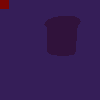

In [235]:
observation_edit = observation[...,2].at[0:9,0:9].set(100.0)
b.get_depth_image(observation_edit)


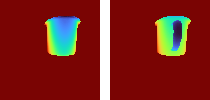

In [236]:
b.hstack_images(
    [
        get_depth_image(observation[...,2]),
        get_depth_image(render_image(sampled_params[0])[...,2]),
    ]
)

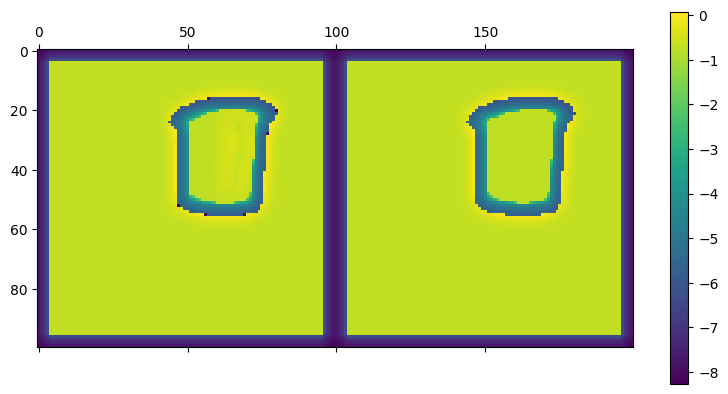

In [237]:
scores = threedp3_likelihood_per_pixel_jit(observation, render_image(sampled_params[0]), variance, outlier_prob, outlier_volume, 4)
scores_gt = threedp3_likelihood_per_pixel_jit(observation, render_image(gt_contact), variance, outlier_prob, outlier_volume, 4)
plt.matshow(jnp.hstack([scores, scores_gt]))
plt.colorbar()

In [166]:
scores.sum() > scores_gt.sum()

Array(True, dtype=bool)

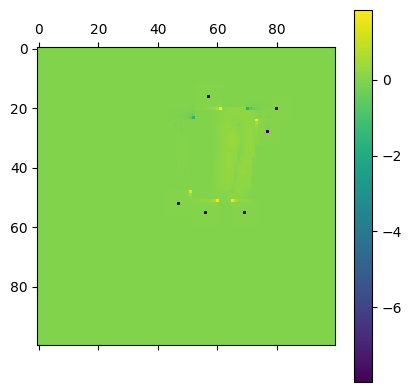

In [188]:
plt.matshow((scores - scores_gt))
plt.colorbar()

2


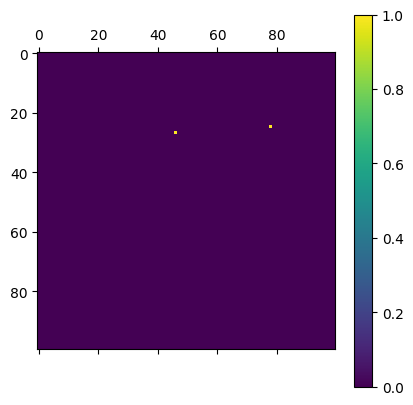

In [108]:
outlier_mask = threedp3_likelihood_per_pixel_jit(observation, render_image(sampled_params[0]), variance, 0.0, outlier_volume, 4) > threedp3_likelihood_per_pixel_jit(observation, render_image(sampled_params[0]), variance, 1.0, outlier_volume, 4)
print(outlier_mask.sum())

plt.matshow(outlier_mask)
plt.colorbar()

3


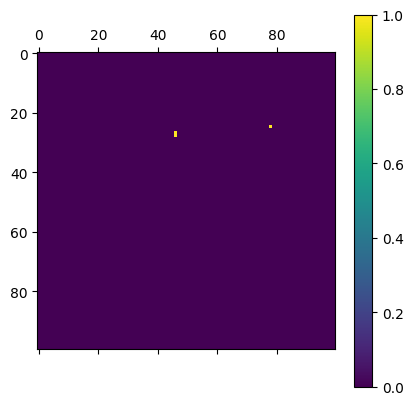

In [73]:
outlier_mask = threedp3_likelihood_per_pixel_jit(observation, render_image(gt_contact), variance, 0.0, outlier_volume, 4) > threedp3_likelihood_per_pixel_jit(observation, render_image(gt_contact), variance, 1.0, outlier_volume, 4)
print(outlier_mask.sum())
plt.matshow(outlier_mask)
plt.colorbar()

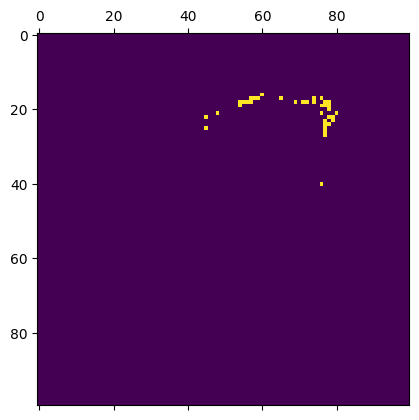

In [285]:
plt.matshow(render_image(sampled_params[0])[...,2] < render_image(gt_contact)[...,2])

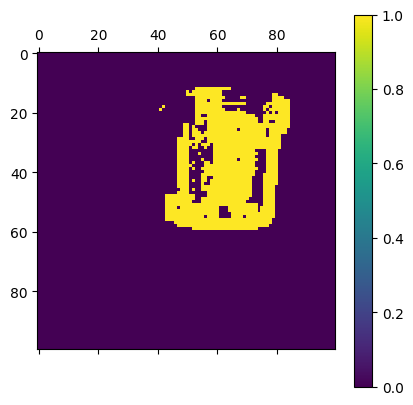

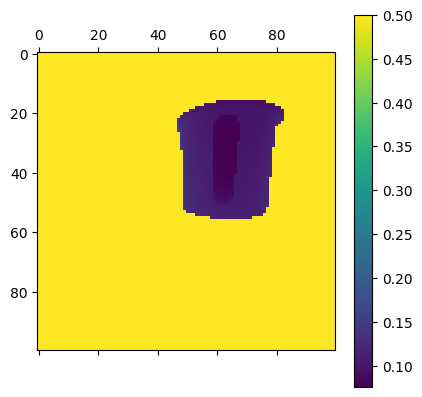

In [44]:
plt.matshow(jnp.clip(render_image(sampled_params[0])[...,2], 0.0, 0.5))
plt.colorbar()


In [41]:
b.clear()
i = 1
p = sampled_params[i]
b.show_trimesh(f"{i}", b.RENDERER.meshes[13])
b.set_pose(f"{i}", get_poses(p, 13)[1])

cloud = render_image(p)[...,:3]
b.show_cloud(f"cloud", cloud.reshape(-1,3))

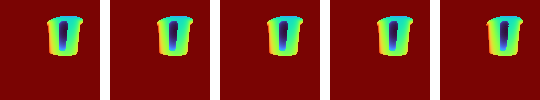

In [43]:
b.hstack_images([
    get_depth_image(render_image(c)[...,2]) for c in sampled_params[:5]
])

In [35]:
b.utils.normalize_log_scores(
    jnp.array([scorer_jit(observation, c, variance, outlier_prob, outlier_volume) for c in sampled_params[:5]])
)

Array([0.35621294, 0.0417207 , 0.35621294, 0.23452449, 0.01115248],      dtype=float32)

In [40]:
b.clear()
b.show_cloud("obs", observation[...,:3].reshape(-1,3))
b.show_cloud("render", render_image(sampled_params[4])[...,:3].reshape(-1,3),color=b.viz.RED)


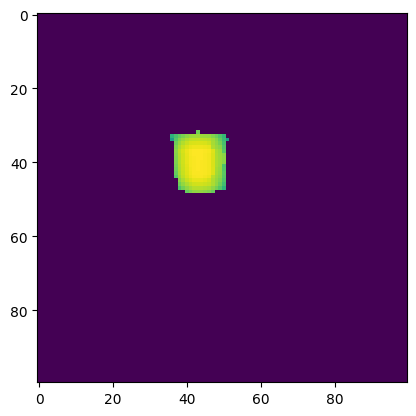

In [44]:
image_scores = threedp3_likelihood_per_pixel(
    observation, render_image(sampled_params[5]), variance, outlier_prob, outlier_volume, 4
)
plt.imshow(image_scores)